Current best training results:

    loss            0.6391
    accuracy        0.7540
    precision         0.68    0.84    0.63
    recall            0.75    0.75    0.77
    fscore            0.72    0.79    0.69
    support           3524    8850    2596
    

# ML

* Consider different time horizons via logsigs / conv layers with different kernels?
* Large spread should be a huge indicator
* Incorporate information about market volatility

# Strategy

* Strategy should be based on my current inventory and pnl
* Ternary trees?
* Which portion of the portfolio (Kelly, fixed proportion of your wealth)?
* If short, don't sell on neutral signal, sell first on opposite signal (if nothing lost yet)
* Avoid very short holding peridos (smoothing, impact ideas)
* Don't give up spread easily if it's huge
* Backtesting: don't cross the spread, place limit orders in anticipation of a big price move
* Place limit orders: what is our anticipation? Expect large drop and rebound (and vice versa)?
* Better smoothing of the strategy, spread should be involved in the optimization problem
* Need to model volatility too if log-utility?
* Movements upwards should be more credible than movements downwards? Incorporate this into the strategy?


# AB Test

* Ordering of the features: (ap, av, bp, bv) vs. (ap, bp, av, bv)
* Selectively remove features to check if they are significant
* Train and validate on the same day vs. different days
* return_sequences True vs. False
* y1 vs. y2

# To-Dos

* Never re-index / reset index: create method integrate that takes strategy and asset price paths and calculates pnl
* Proper scaling and transforms
* Integrate not at the best price, but take into account slippage
* Market impact: instantaneous vs. permanent
* Fees
* Consider deeper order book

# Fixes

* ewm at the beginning of the period is what?

In [2]:
import pandas as pd
from csv import writer
from tqdm import tqdm
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras import Model
from keras.layers import Input, LSTM, Conv1D, Conv2D, Reshape, Dense, BatchNormalization, Dropout, concatenate
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from model import *
from utils import *

In [42]:
# size of the time-series slice used as input to the NN
WINDOW_SIZE = 100

# ewm strategy center of mass
COM = 10

# ewm strategy scaling of indicators
GAMMA = 20

# features
FEATURES = ['timestamp_diff']

DEPTH = 20

MODEL = '20210714_000000'

In [ ]:
apcs = [f'ap_{i}' for i in range(DEPTH)]
avcs = [f'av_{i}' for i in range(DEPTH)]
bpcs = [f'bp_{i}' for i in range(DEPTH)]
bvcs = [f'bv_{i}' for i in range(DEPTH)]

keys = [x for items in zip(apcs, bpcs, avcs, bvcs) for x in items]

# Data

In [43]:
model = build_model(window_size=WINDOW_SIZE, n_features=len(FEATURES), depth=DEPTH)
model.load_weights(f'_output/models/{MODEL}.h5')

backtesting:

* many assets
* fees
* slippage
* limit orders

# Backtest

In [24]:
def integrate(df, strategy_column='strategy', bid_column='best_bid_price', ask_column='best_ask_price'):
    
    df = df[[bid_column, ask_column, strategy_column]]
    df = df[~df.isna().any(axis=1)]
    
    strategy_diff = df[strategy_column].shift(1).fillna(0).diff(-1).fillna(0)
    
    # buy at best ask, sell at best bid (simplied assumption without slippage)
    money_diff = df[bid_column] * np.maximum(strategy_diff, 0)
    money_diff += df[ask_column] * np.minimum(strategy_diff, 0)
    
    # shift by one. at time zero, integral is always zero
    money_diff = money_diff.shift(1).fillna(0)
    money_account = np.cumsum(money_diff)
    
    # assumption is that we always cross the spread so pay the fees
    fees = np.cumsum(0.0005 * np.abs(money_diff))
    
    portfolio_value = (df[strategy_column] * df[bid_column]).shift(1).fillna(0)
    pnl = money_account + portfolio_value
    
    retval_df = df[[bid_column, ask_column, strategy_column]].rename(columns={bid_column: 'bid', ask_column: 'ask', strategy_column: 'strategy'})
    retval_df['fees'] = fees
    retval_df['money'] = money_account
    retval_df['pnl'] = pnl
    
    return retval_df


In [52]:
def create_strategy(df, gamma=1, com=10):
        
    # predict returns
    X1, X2 = split(df, 1, WINDOW_SIZE)
    
    # predict returns
    ret_pred = model.predict([X1, X2])
    strategy = np.argmax(ret_pred, axis=1) - 1.

    # calculating ewm strategy
    retval_df = df[['timestamp_diff', 'best_bid_price', 'best_ask_price']].copy()
    retval_df.loc[retval_df.index[WINDOW_SIZE:], ['p-', 'p0', 'p+']] = ret_pred
    retval_df.loc[retval_df.index[WINDOW_SIZE:], 'strategy'] = gamma * strategy.reshape(-1)
    
    strategy_name = f"ewm_strategy_{com}_{gamma}"
    retval_df.loc[retval_df.index[WINDOW_SIZE:], strategy_name] = np.minimum(1., np.maximum(-1., np.round(retval_df['strategy'].ewm(com=com).mean())))
    retval_df = retval_df[~retval_df.isna().any(axis=1)]
    
    # avoid holding zero on neutral signal, hold -1 or 1 instead continuously until opposite signal prevails
    retval_df[strategy_name] = retval_df[strategy_name].replace(to_replace=0, method='ffill')
    
    retval_df.loc[:, ['money', 'pnl', 'fees']] = integrate(retval_df, strategy_name)
    retval_df['n_trades'] = np.cumsum(retval_df[strategy_name].diff(1).fillna(0) != 0)

    return retval_df


In [98]:
dfx = pd.read_csv('_input/data/20210712_000000.csv')[1400:1500]
bid, ask = dfx.iloc[-1][['best_bid_price', 'best_ask_price']]
mid_price = (bid + ask) / 2
dfx.loc[:, apcs + bpcs] = dfx.loc[:, apcs + bpcs].sub(mid_price)

,ap_0,ap_1,ap_2,ap_3,ap_4,ap_5,ap_6,ap_7,ap_8,ap_9,bp_0,bp_1,bp_2,bp_3,bp_4,bp_5,bp_6,bp_7,bp_8,bp_9
1400,-8.25,-7.75,-4.75,-4.25,-3.75,-2.75,-1.75,0.75,1.25,2.25,-8.75,-12.75,-14.75,-16.75,-17.75,-18.75,-19.25,-19.75,-20.25,-20.75
1401,-8.25,-7.75,-4.75,-4.25,-3.75,-2.75,-1.75,0.75,1.25,2.25,-8.75,-12.75,-14.75,-16.75,-17.75,-18.75,-19.25,-19.75,-20.25,-20.75
1402,-8.25,-7.75,-5.25,-4.75,-4.25,-3.75,-1.75,0.75,1.25,2.25,-8.75,-12.75,-14.75,-16.75,-17.75,-18.75,-19.25,-19.75,-20.25,-20.75
1403,-8.25,-7.75,-5.25,-4.75,-4.25,-3.75,-1.75,-0.75,0.75,1.25,-8.75,-12.75,-14.75,-16.75,-17.75,-18.75,-19.25,-19.75,-20.25,-20.75
1404,-8.25,-7.75,-7.25,-5.25,-4.75,-4.25,-3.75,-1.75,-0.75,0.75,-8.75,-12.75,-14.75,-16.75,-17.75,-18.75,-19.25,-19.75,-20.25,-20.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,0.25,4.75,5.25,5.75,6.25,7.25,8.25,8.75,9.25,9.75,-0.25,-2.25,-3.75,-4.75,-6.25,-7.25,-8.75,-9.75,-10.75,-11.25
1496,0.25,4.75,5.25,5.75,6.25,7.25,8.25,8.75,9.25,9.75,-0.25,-2.25,-3.75,-4.75,-6.25,-7.25,-8.75,-9.75,-10.75,-11.25
1497,0.25,3.25,4.75,5.25,5.75,6.25,7.25,8.25,8.75,9.25,-0.25,-2.25,-3.75,-4.75,-6.25,-7.25,-8.75,-9.75,-10.75,-11.25
1498,0.25,3.25,4.75,5.25,5.75,6.25,7.25,8.25,8.75,9.25,-0.25,-2.25,-3.75,-4.75,-6.25,-7.25,-8.75,-9.75,-10.75,-11.25


In [15]:
# load backtest dataset
df = pd.read_csv('_input/data/20210712_000000.csv')
df.index = pd.to_datetime(df['timestamp']*1000*1000)
assert df.index.is_unique

# prepare backtest dataset
df = prepare_df1(df)

df20 = create_strategy(df, gamma=GAMMA, com=COM)
#df20.style.background_gradient(cmap='coolwarm', subset=(dff.index, ['y2', 'strategy', 'ewm_strategy_10']))

/Users/konstantinisstarovoitovs/projects/deribot/utils.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, data.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)
/Users/konstantinisstarovoitovs/projects/deribot/utils.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, data.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)


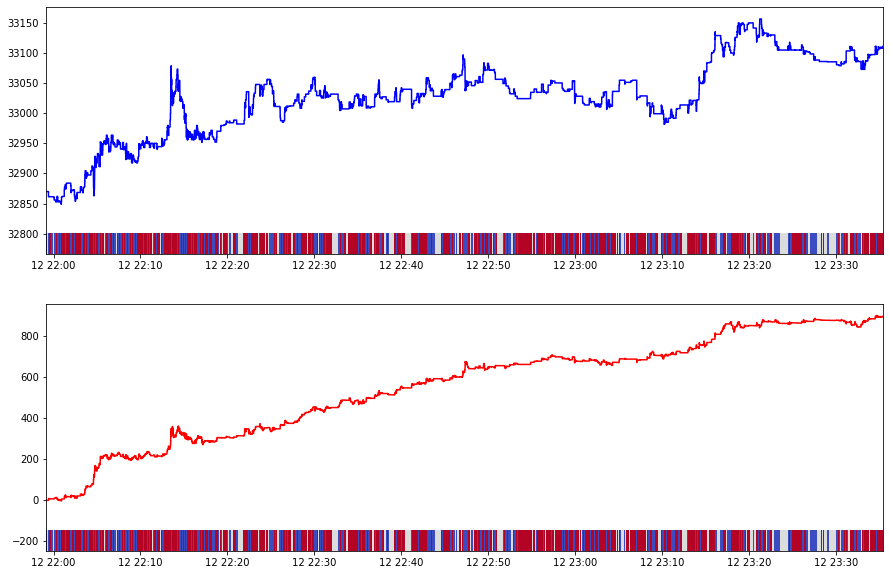

In [16]:
STEP = 100000
OFFSET = 0

df0 = df20[OFFSET:OFFSET+STEP]

strategy_name = f'ewm_strategy_{COM}_{GAMMA}'

fig, ax = plt.subplots(figsize=(15, 10), nrows=2)

ax[0].step(df0.index, df0['best_bid_price'], c='b')
add_pcolor_to_plot(ax[0], df0[strategy_name])

ax[1].step(df0.index, df0['pnl'], c='r')
add_pcolor_to_plot(ax[1], df0[strategy_name])

/Users/konstantinisstarovoitovs/projects/deribot/utils.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, data.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)
/Users/konstantinisstarovoitovs/projects/deribot/utils.py:22: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax.pcolor(X, Y, data.to_numpy().reshape(1, -1), cmap='coolwarm', alpha=1., vmin=-1., vmax=1.)
/Users/konstantinisstarovoitovs/projects/deribot/utils.py:

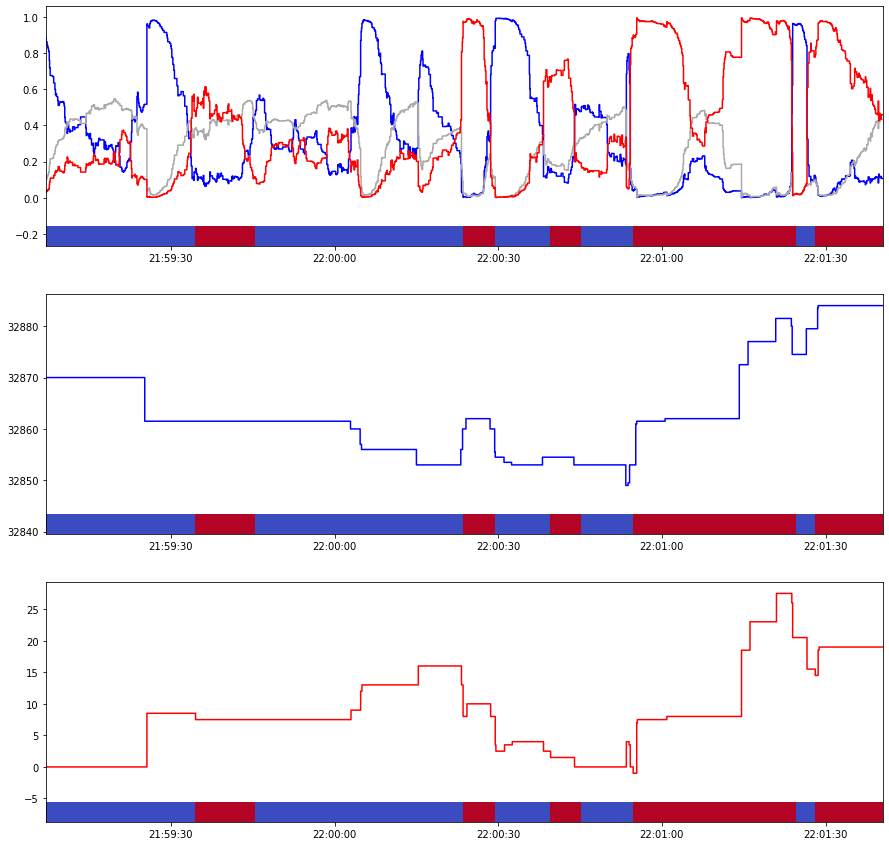

In [59]:
STEP = 1000
OFFSET = 0

df0 = df30[OFFSET:OFFSET+STEP]

strategy_name = f'ewm_strategy_{COM}_{GAMMA}'

fig, ax = plt.subplots(figsize=(15, 15), nrows=3)
ax[0].step(df0.index, df0['p-'], c='b')
ax[0].step(df0.index, df0['p0'], c='darkgray')
ax[0].step(df0.index, df0['p+'], c='r')
add_pcolor_to_plot(ax[0], df0[strategy_name])

ax[1].step(df0.index, df0['best_bid_price'], c='b')
add_pcolor_to_plot(ax[1], df0[strategy_name])

ax[2].step(df0.index, df0['pnl'], c='r')
add_pcolor_to_plot(ax[2], df0[strategy_name])